In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import beam_generator

In [2]:
plt.style.use('science')

Consider the problem of diffraction of a plane wave on a rectangular aperture with dimensions $D=0.1~mm$ and $d=0.5~mm$. The size of the screen on which the pattern is observed is $length \cdot length$. 

In [3]:
D = 0.1
d = 0.5
lam = 660 * 1e-6
length = 2

wave_vector = 2* torch.pi / lam

Nx = 1600
Ny = 1600
x_length = np.linspace(-length, length, Nx)
y_length = np.linspace(-length, length, Ny)

# creating the meshgrid
xv, yv = np.meshgrid(x_length, y_length)

params = SimulationParameters(
    x_size=2 * length,
    y_size=2 * length,
    x_nodes=Nx,
    y_nodes=Ny,
    wavelength=lam
)

In [4]:
# create plane  before the aperture
z = 3 * 1e1
plane_wave = beam_generator.PlaneWave(simulation_parameters=params).forward(
    distance=z, wave_vector=torch.tensor([0., 0., wave_vector])
)

# create rectangular aperture
rectangular_aperture = elements.RectangularAperture(
    simulation_parameters=params, height=d, width=D
)

field_after_aperture = rectangular_aperture.forward(input_field=plane_wave)
aperture_shape = rectangular_aperture.get_transmission_function().detach().numpy()

Let us look at the intensity distribution $I$ in the plane in front of the rectangular aperture and the shape of the aperture:

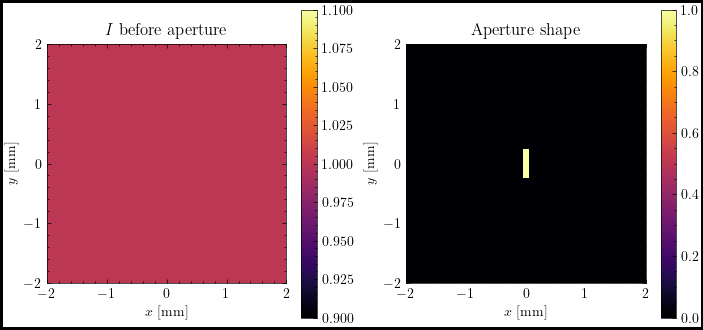

In [5]:
intensity_before_aperture = torch.pow(torch.abs(plane_wave), 2).detach().numpy()

fig, ax = plt.subplots(
    1, 2, figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(xv, yv, intensity_before_aperture, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'$I$ before aperture')
ax[0].set_xlabel('$x$ [mm]')
ax[0].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(xv, yv, aperture_shape, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title(r'Aperture shape')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im2)

Let us find the field falling on the screen after passing the aperture at the distance $z=3~cm$ and the intensity distribution $I_{screen}(x, y)$:

In [6]:
field = elements.FreeSpace(
    simulation_parameters=params, distance=z, method='AS'
    ).forward(input_field=field_after_aperture)

intensity = torch.pow(torch.abs(field), 2).detach().numpy()

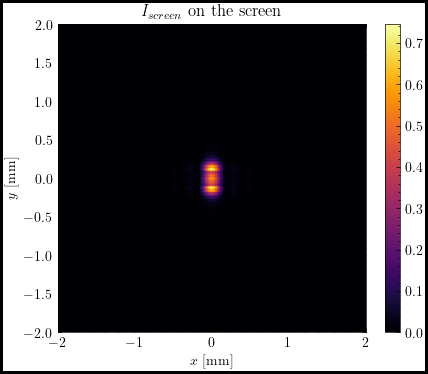

In [7]:
fig, ax = plt.subplots(
    figsize=(5, 4), edgecolor='black', linewidth=3, frameon=True
)
im = ax.pcolormesh(xv, yv, intensity, cmap='inferno')
ax.set_aspect('equal')
ax.set_title(r'$I_{screen}$ on the screen')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im)

Using the diffraction grating equation $D \sin{\theta}=m\lambda$, where m is the order of diffraction, we can find the position of the intensity minima:

In [8]:
# array of min
m  = np.arange(1,8,1)
x_min = np.sqrt(m**2 * lam**2 * z**2 / (D**2 - m**2 * lam**2))

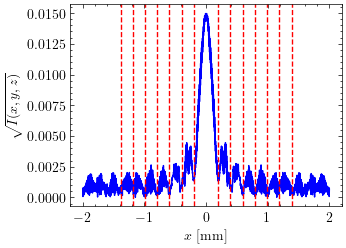

In [9]:
plt.plot(x_length, np.sqrt(intensity)[250], color='blue')
[plt.axvline(x, ls='--', color='r') for x in x_min]
[plt.axvline(-x, ls='--', color='r') for x in x_min]

plt.xlabel('$x$ [mm]')
plt.ylabel('$\sqrt{I(x,y,z)}$')
plt.show()